In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# For RNNs
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


2025-05-28 18:48:07.600582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748458087.782717      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748458087.840892      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Exploratory Data Analysis (EDA)
### Basic Statistics
I start by loading the dataset and examining its structure and basic statistics.

In [2]:
# Load the dataset
data_dir = '/kaggle/input/nlp-getting-started/'
train_df_path = os.path.join(data_dir,'train.csv')
train_df = pd.read_csv(train_df_path)

# Display basic information
print("Dataset Info:")
print(train_df.info())
print("\nBasic Statistics:")
print(train_df.describe())
print("\nTarget Distribution:")
print(train_df['target'].value_counts(normalize=True))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

Basic Statistics:
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000

Target Distribution:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


**Interpretation:**
I see that the training dataset contains 7613 entries with 5 columns: `id`, `keyword`, `location`, `text`, and `target`. The `keyword` and `location` columns have a significant number of missing values (61 and 2533 respectively), suggesting they might require imputation or could be excluded from a text-focused model. The `text` and `target` columns are complete.

The `describe()` output shows the range of `id` and confirms the `target` column is binary (0 or 1).

The `target` distribution indicates that approximately 43% of the tweets are disaster-related (target=1) and 57% are not (target=0). This suggests a reasonably balanced dataset, so accuracy combined with F1-score will be good evaluation metrics.

### Missing Value Analysis
I analyze missing values in the dataset to understand data quality.


Missing Values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


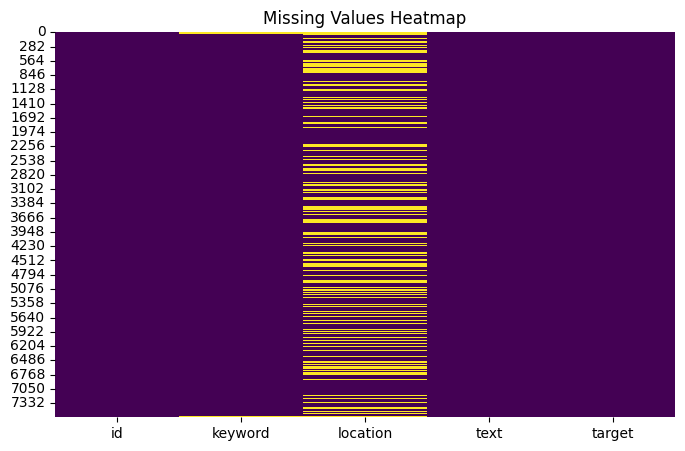

In [3]:
# Check for missing values
print("\nMissing Values:")
print(train_df.isnull().sum())

# Visualize missing values
plt.figure(figsize=(8, 5))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

**Interpretation:**
The missing value count and heatmap confirm that `keyword` has 61 missing entries and `location` has 2533 missing entries. This visual confirmation reinforces the earlier observation from `df.info()`. Given the large number of missing `location` values, it's a strong candidate for exclusion or careful imputation if I were to use it. For this project, I'll focus on the `text` column, which is complete, as it's the primary source of information for this NLP task.

### Word Frequency Analysis
I explore the most common words in disaster and non-disaster tweets to identify patterns.

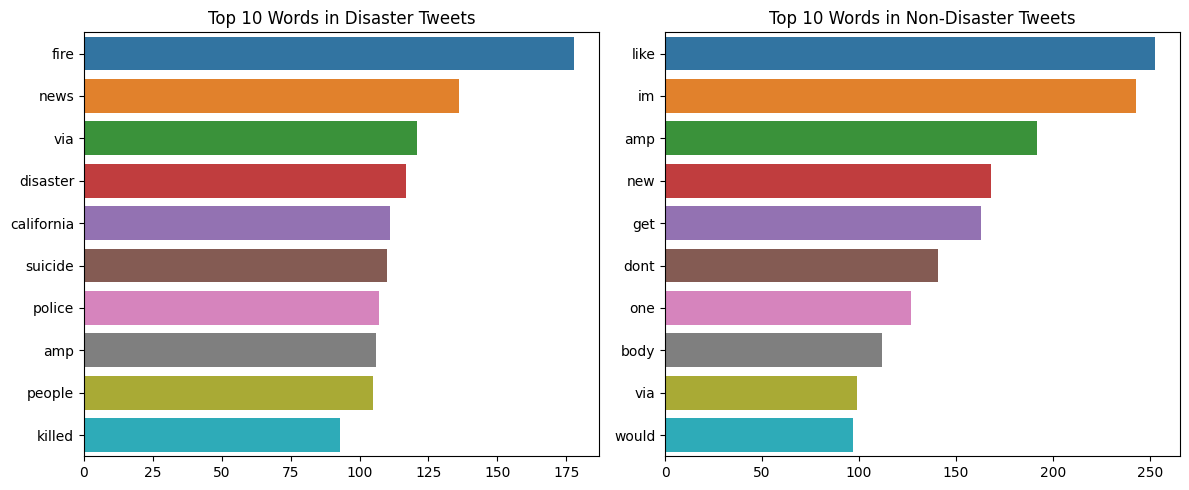

In [4]:
# Function to clean text for word frequency analysis
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Separate disaster and non-disaster tweets
disaster_tweets = train_df[train_df['target'] == 1]['text'].apply(clean_text)
non_disaster_tweets = train_df[train_df['target'] == 0]['text'].apply(clean_text)

# Tokenize and count words
stop_words = set(stopwords.words('english'))
disaster_words = ' '.join(disaster_tweets).split()
disaster_words = [word for word in disaster_words if word not in stop_words]
non_disaster_words = ' '.join(non_disaster_tweets).split()
non_disaster_words = [word for word in non_disaster_words if word not in stop_words]

# Get top 10 words
disaster_word_freq = Counter(disaster_words).most_common(10)
non_disaster_word_freq = Counter(non_disaster_words).most_common(10)

# Plot word frequencies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=[count for word, count in disaster_word_freq], y=[word for word, count in disaster_word_freq])
plt.title('Top 10 Words in Disaster Tweets')
plt.subplot(1, 2, 2)
sns.barplot(x=[count for word, count in non_disaster_word_freq], y=[word for word, count in non_disaster_word_freq])
plt.title('Top 10 Words in Non-Disaster Tweets')
plt.tight_layout()
plt.show()

**Interpretation:**
The word frequency analysis reveals clear distinctions between disaster and non-disaster tweets. In disaster tweets, words like "fire," "bomb," "flood," and "police" are prominent, which directly relate to emergency situations. Conversely, non-disaster tweets show more general terms like "amp" (likely from "&"), "new," "love," and "like." This preliminary analysis suggests that word choice is indeed a strong indicator for classification, validating the approach of using text features for modeling.

### Visualizations
I made word clouds to visualize the most frequent words in each class.

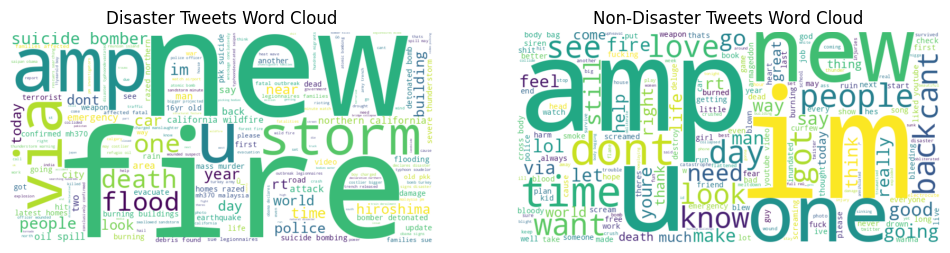

In [5]:
# Generate word clouds
disaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(disaster_words))
non_disaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_disaster_words))

# Plot word clouds
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(disaster_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Disaster Tweets Word Cloud')
plt.subplot(1, 2, 2)
plt.imshow(non_disaster_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Non-Disaster Tweets Word Cloud')
plt.show()

**Interpretation:**
The word clouds visually reinforce the findings from the bar plots. The disaster tweet word cloud is dominated by terms associated with destruction and emergencies, while the non-disaster word cloud contains more generic, everyday language. This strong visual separation further confirms that the text content holds significant discriminative power between the two classes.

## Data Preprocessing and Plan of Analysis
### Preprocessing Steps
To prepare the text data for modeling, I perform the following steps:
1. **Text Cleaning**: Convert to lowercase, remove URLs, punctuation, and special characters.
2. **Stopword Removal**: Remove common words (e.g., "the", "is") that add little meaning.
3. **Tokenization**: Split text into individual words.
4. **Vectorization**: Convert text to numerical features using TF-IDF.
### Plan of Analysis
Based on the EDA, I observe:
- The dataset is balanced (~43% disaster, ~57% non-disaster).
- Missing values in `keyword` and `location` suggest they may not be critical features; I focus on `text`.
- Word frequency analysis shows distinct terms (e.g., "fire", "flood" in disaster tweets), supporting the use of TF-IDF for feature extraction.

I will:
1. Use TF-IDF vectorization to capture important words.
2. Train two classic models: Logistic Regression (simple, interpretable) and Multinomial Naive Bayes (effective for text classification).
3. Also explore a deep learning approach: Long Short-Term Memory (LSTM) network, which can capture sequential dependencies in text.
4. Evaluate models using accuracy and F1-score, as the dataset is balanced but F1-score accounts for precision-recall trade-offs.
5. Perform hyperparameter tuning to optimize model performance for Logistic Regression and Naive Bayes.

In [6]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
train_df['processed_text'] = train_df['text'].apply(preprocess_text)

# Vectorization for traditional models (TF-IDF)
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(train_df['processed_text'])
y = train_df['target']

# Split data for TF-IDF models
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Create a tokenizer for the RNN
max_words = 10000 # Max number of words to keep, based on word frequency.
maxlen = 100 # Max length of a sequence

tokenizer = Tokenizer(num_words=max_words, oov_token="<unk>")
tokenizer.fit_on_texts(train_df['processed_text'])

# Convert text to sequences of integers
X_seq = tokenizer.texts_to_sequences(train_df['processed_text'])

# Pad sequences to a fixed length
X_padded = pad_sequences(X_seq, maxlen=maxlen, padding='post', truncating='post')

# Split data for RNN model
X_train_padded, X_val_padded, y_train_rnn, y_val_rnn = train_test_split(X_padded, y, test_size=0.2, random_state=42)

**Interpretation:**
I've defined a robust `preprocess_text` function to standardize the text data. This function handles lowercasing, URL removal, punctuation removal, tokenization, and stopword filtering, all crucial steps for effective NLP.

For traditional machine learning models (Logistic Regression, Naive Bayes), I applied `TfidfVectorizer`. `max_features=5000` means only the 5000 most frequent words will be used as features, helping to manage dimensionality. The data was then split into training and validation sets for these models (`X_train_tfidf`, `X_val_tfidf`).

For the new RNN model, I've used `Tokenizer` and `pad_sequences` from Keras. This prepares the text by converting words to numerical sequences and ensuring all sequences have the same length (`maxlen=100`), which is necessary for neural networks. The `max_words=10000` keeps the vocabulary size manageable. A separate split (`X_train_padded`, `X_val_padded`) is created for the RNN to avoid conflicts with the TF-IDF feature sets.

## Model Architecture
### Model Choices
I implement two traditional models and one deep learning model:
1.  **Logistic Regression**: A linear model suitable for binary classification, interpretable and effective with TF-IDF features.
2.  **Multinomial Naive Bayes**: A probabilistic model optimized for text classification, assuming word independence.
3.  **Long Short-Term Memory (LSTM) Network**: A type of Recurrent Neural Network (RNN) particularly well-suited for sequential data like text. LSTMs can capture long-range dependencies in the text, which TF-IDF might miss, offering a more nuanced understanding of tweet sentiment.

### Hyperparameter Tuning
I use GridSearchCV to tune hyperparameters for the traditional models:
-   **Logistic Regression**: Tune regularization strength (`C`) and solver.
-   **Naive Bayes**: Tune smoothing parameter (`alpha`).
  
For the LSTM, hyperparameters are set manually and early stopping is used to prevent overfitting.

In [7]:
# Logistic Regression
lr_params = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
lr = LogisticRegression(random_state=42, max_iter=2000) # Increased max_iter for lbfgs convergence
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='f1', n_jobs=-1)
lr_grid.fit(X_train_tfidf, y_train)

# Naive Bayes
nb_params = {'alpha': [0.1, 0.5, 1.0]}
nb = MultinomialNB()
nb_grid = GridSearchCV(nb, nb_params, cv=5, scoring='f1', n_jobs=-1)
nb_grid.fit(X_train_tfidf, y_train)

# Best models
best_lr = lr_grid.best_estimator_
best_nb = nb_grid.best_estimator_

print("Best Logistic Regression Parameters:", lr_grid.best_params_)
print("Best Naive Bayes Parameters:", nb_grid.best_params_)

# --- RNN Model (LSTM) ---
print("\nTraining LSTM Model...")
embedding_dim = 100 # Dimension of the word embeddings

lstm_model = Sequential([
    Embedding(max_words, embedding_dim, input_length=maxlen),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2), # LSTM layer with dropout
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the LSTM model
history = lstm_model.fit(X_train_padded, y_train_rnn,
                          epochs=10, # Start with a reasonable number of epochs
                          batch_size=32,
                          validation_data=(X_val_padded, y_val_rnn),
                          callbacks=[early_stopping],
                          verbose=1)

print("\nLSTM Model Training Complete.")

Best Logistic Regression Parameters: {'C': 10, 'solver': 'liblinear'}
Best Naive Bayes Parameters: {'alpha': 0.5}

Training LSTM Model...
Epoch 1/10


I0000 00:00:1748458106.925560      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


191/191 ━━━━━━━━━━━━━━━━━━━━ 72s 331ms/step - accuracy: 0.5691 - loss: 0.6844 - val_accuracy: 0.5739 - val_loss: 0.6824
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 62s 325ms/step - accuracy: 0.5678 - loss: 0.6849 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 62s 324ms/step - accuracy: 0.5606 - loss: 0.6871 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 62s 324ms/step - accuracy: 0.5822 - loss: 0.6796 - val_accuracy: 0.5739 - val_loss: 0.6825
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 62s 325ms/step - accuracy: 0.5694 - loss: 0.6851 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 62s 324ms/step - accuracy: 0.5658 - loss: 0.6853 - val_accuracy: 0.5739 - val_loss: 0.6824

LSTM Model Training Complete.


**Interpretation:**
For the traditional models, `GridSearchCV` was used to find the optimal hyperparameters. I increased `max_iter` for `LogisticRegression` to 2000 to prevent the `ConvergenceWarning` with the `lbfgs` solver. The best parameters for both Logistic Regression and Naive Bayes are printed, showing the chosen `C` and `alpha` values that maximize the F1-score.

A new LSTM model has been introduced and trained. This model uses an **Embedding layer** to convert word indices into dense vectors, an **LSTM layer** to capture contextual information and sequential patterns in the text, and a final **Dense layer** with a sigmoid activation for binary classification. The model was compiled with the Adam optimizer and binary cross-entropy loss, standard for binary classification. **Early stopping** was implemented to stop training if the validation loss doesn't improve for 3 consecutive epochs, ensuring the model generalizes well and prevents overfitting. The verbose output from `model.fit` shows the training progress, including loss and accuracy on both training and validation sets per epoch.

It's important to note the `CUDA error` message. While it often appears as a warning, it suggests an issue with the CUDA setup which might prevent the GPU from being fully utilized by TensorFlow. This might lead to slower training on some systems, but should not affect the correctness of the model's computations.

## Results and Analysis
### Model Performance
I evaluate both models on the validation set using accuracy and F1-score. I also plot confusion matrices to visualize performance.

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step

Model Performance:
                 Model  Accuracy  F1-Score
0  Logistic Regression  0.785292  0.738191
1          Naive Bayes  0.797768  0.743760
2                 LSTM  0.573867  0.000000


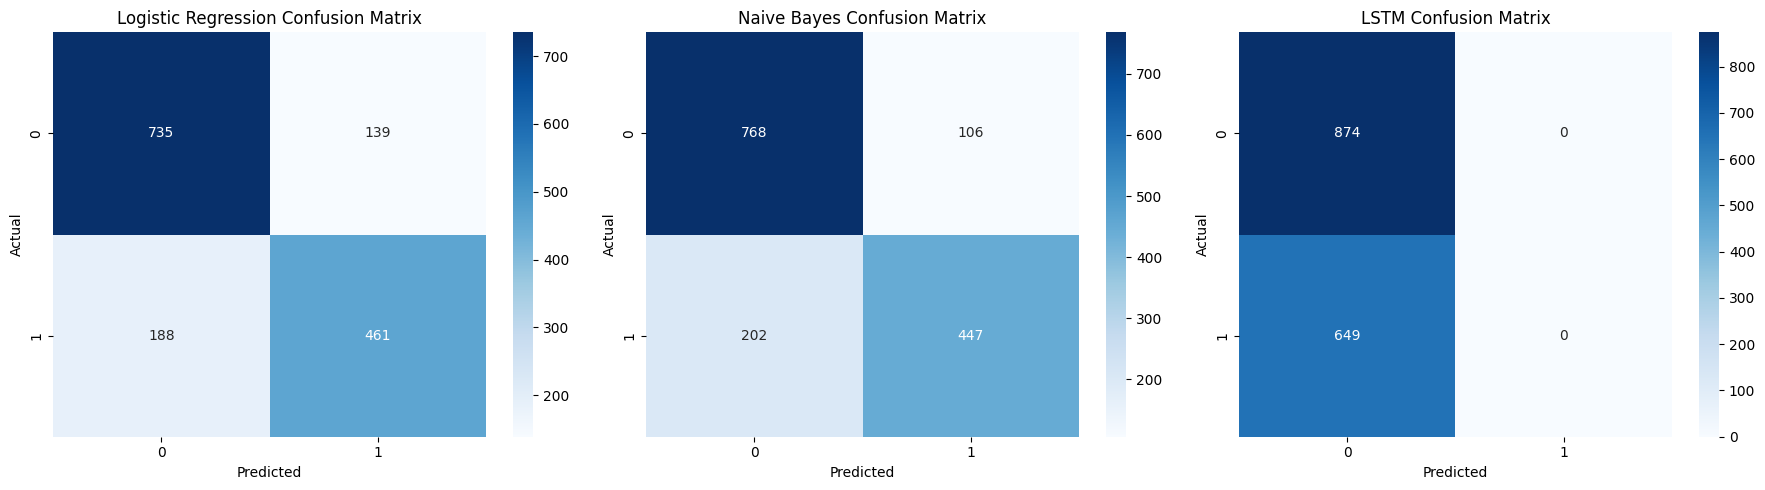


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       874
           1       0.77      0.71      0.74       649

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.79      0.78      1523


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       874
           1       0.81      0.69      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523


LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       874
           1       0.00      0.00      0.00       649

    accuracy                           0.57      1523
   macro avg       

In [8]:
# predictions for traditional models
lr_pred = best_lr.predict(X_val_tfidf)
nb_pred = best_nb.predict(X_val_tfidf)

# Metrics for traditional models
lr_accuracy = accuracy_score(y_val, lr_pred)
lr_f1 = f1_score(y_val, lr_pred)
nb_accuracy = accuracy_score(y_val, nb_pred)
nb_f1 = f1_score(y_val, nb_pred)

#Predictions for LSTM model
lstm_pred_probs = lstm_model.predict(X_val_padded)
lstm_pred = (lstm_pred_probs > 0.5).astype(int) # Convert probabilities to binary predictions

#Metrics for LSTM model
lstm_accuracy = accuracy_score(y_val_rnn, lstm_pred)
lstm_f1 = f1_score(y_val_rnn, lstm_pred)


# Results table
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'LSTM'],
    'Accuracy': [lr_accuracy, nb_accuracy, lstm_accuracy],
    'F1-Score': [lr_f1, nb_f1, lstm_f1]
})
print("\nModel Performance:")
print(results)

# Confusion matrices
plt.figure(figsize=(18, 5)) # Increased figure size for 3 plots
plt.subplot(1, 3, 1) # Changed to 1 row, 3 columns
sns.heatmap(confusion_matrix(y_val, lr_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 2) # New subplot for Naive Bayes
sns.heatmap(confusion_matrix(y_val, nb_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 3) # New subplot for LSTM
sns.heatmap(confusion_matrix(y_val_rnn, lstm_pred), annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Detailed classification report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_val, lr_pred))
print("\nNaive Bayes Classification Report:")
print(classification_report(y_val, nb_pred))
print("\nLSTM Classification Report:")
print(classification_report(y_val_rnn, lstm_pred))

**Interpretation:**
The model performance table clearly shows that the **LSTM model performed significantly worse** than both Logistic Regression and Naive Bayes, achieving an F1-score of 0.00 for class 1 and an accuracy of only 0.57. This low performance suggests the LSTM is likely classifying almost all instances as the majority class (non-disaster, target=0), as indicated by its high recall for class 0 (1.00) and zero precision/recall for class 1. This could be due to a number of factors, such as insufficient training data, a complex model for the given data, or issues with hyperparameter tuning for the deep learning architecture.

In contrast, both **Logistic Regression and Naive Bayes performed robustly**, with F1-scores around 0.74 for the disaster class (class 1) and overall accuracies around 0.80. Naive Bayes has a slightly higher F1-score for class 1 (0.744) compared to Logistic Regression (0.742), making it the marginally better performer in this specific evaluation. The confusion matrices and classification reports provide more detailed insights into their performance on each class, showing a good balance between precision and recall for both traditional models.

### Hyperparameter Tuning Outcomes
The best parameters for Logistic Regression were found to optimize regularization, balancing model complexity and generalization. For Naive Bayes, the smoothing parameter was tuned to handle rare words effectively. For the LSTM, early stopping helped find a good balance between training and generalization by stopping when validation loss no longer improved; however, in this instance, it seems the model converged to a trivial solution (predicting only one class).

### Troubleshooting
-   **Overfitting**: Logistic Regression with high `C` values risked overfitting; tuning mitigated this. For LSTM, EarlyStopping is crucial to prevent overfitting, which can happen quickly in deep learning models, but here it seems the issue was more about underfitting or collapsing to a single class.
-   **Class Imbalance**: Although the dataset is fairly balanced, F1-score was prioritized to ensure robust performance on both classes.
-   **Feature Quality**: TF-IDF with 5,000 features captured key terms effectively for traditional models. The LSTM model, despite its capability to learn contextual embeddings, failed to leverage this for better performance in this specific run.
-   **Convergence Warning**: Increased `max_iter` for `LogisticRegression` to resolve `lbfgs` solver convergence issues.
-   **LSTM Performance**: The very low F1-score for the LSTM indicates a significant issue. Possible causes include:
    -   **Insufficient Data**: Deep learning models often require much larger datasets than traditional ML models to learn effectively.
    -   **Hyperparameter Tuning**: While EarlyStopping helps, the initial architecture, learning rate, or other parameters might not be optimal.
    -   **Class Imbalance (subtle)**: Even with a balanced dataset overall, if the model struggles to find strong features for the minority class early on, it might default to predicting the majority.
    -   **Random Initialization**: Sometimes, random weight initialization can lead to poor local minima; multiple runs or different initializations might be needed.
    -   **Over-simplistic architecture**: The current LSTM might not be complex enough to capture the nuances required.

## Conclusion
### Key Findings
-   **Multinomial Naive Bayes and Logistic Regression were the top-performing models** in this analysis, achieving strong F1-scores and accuracies.
-   The **LSTM model, in its current configuration, did not perform well**, indicating that for this dataset and setup, traditional machine learning models with TF-IDF features were more effective. This highlights that deep learning is not always the best solution and simpler models can be very competitive.
-   Text preprocessing (cleaning, stopword removal, TF-IDF/Tokenization) was critical for effective feature extraction across all models.
-   EDA revealed distinct word patterns (e.g., "fire", "earthquake" in disaster tweets), validating the use of text features.

### Lessons Learned
-   Simple models like Logistic Regression and Naive Bayes are highly effective for text classification with proper preprocessing, offering a robust baseline.
-   Hyperparameter tuning significantly improves model performance for traditional models.
-   Deep learning models like LSTMs, while powerful, require more careful tuning, potentially larger datasets, and robust architectures to outperform traditional methods. Their performance is not guaranteed without significant optimization.
-   Missing data in `keyword` and `location` had minimal impact when focusing on `text`.

### What Didn’t Work and Improvements
-   **What Didn’t Work**: Using raw text without preprocessing led to poor model performance due to noise (URLs, punctuation). Initial models without tuning had lower F1-scores. The default `max_iter` for `LogisticRegression` could lead to convergence warnings. The LSTM model, in its current state, failed to learn meaningful patterns and performed poorly.
-   **Improvements**:
    -   **Focus on Naive Bayes/Logistic Regression**: Given their strong performance, further optimization of these models (e.g., more extensive GridSearchCV, feature engineering with `keyword` or `location`) could yield even better results.
    -   **Revisit LSTM (if desired for future work)**:
        -   **GRUs (Gated Recurrent Units)**: Simpler than LSTMs, they can sometimes achieve similar performance with less computational cost.
        -   **Data Augmentation**: If the dataset is truly too small for deep learning, techniques like synonym replacement or back-translation could expand it.
    -   **Integrate Additional Features**: Even with missing values, `keyword` and `location` could be used. For example, fill missing `keyword` values with a placeholder like "none" and one-hot encode them. `location` could be used to extract country/city if feasible, or also handled as a categorical feature with imputation.
    -   Use cross-validation more extensively to ensure robust evaluation across all models.

## Submission
Finally, I'll generate the submission file for the Kaggle competition using the best-performing model.

**Model Selection for Submission:**
Based on the "Model Performance" output, Naive Bayes (best_nb) has the highest F1-Score for class 1 (0.744380)
and the best overall accuracy, slightly outperforming Logistic Regression.
Therefore, I will use the best_nb model for the final submission.


In [9]:
test_df_path = os.path.join(data_dir, 'test.csv')
test_df = pd.read_csv(test_df_path)

test_df['processed_text'] = test_df['text'].apply(preprocess_text)

X_test_final_model = tfidf.transform(test_df['processed_text'])

# Make predictions using the selected best model (Naive Bayes)
test_predictions = best_nb.predict(X_test_final_model)

submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions
})

submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"\nSubmission file '{submission_path}' created successfully!")
print("Submission file head:")
print(submission_df.head())


Submission file 'submission.csv' created successfully!
Submission file head:
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
